In [2]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/NYU/ML_Sundeep/project

Mounted at /content/gdrive
/content/gdrive/My Drive/NYU/ML_Sundeep/project


In [3]:
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt

from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [68]:
parser = {
    "root": os.getcwd(),
    "seed": 1,
    "cuda": True,
    "object_change": False, # style change the detective object; otherwise change the background
    "num_classes": 2, # depend on how many classes that the segmentation model has trained on
    "model_path": "intermediate/segmentation.p",
    "imsize": (1000, 800),
    "style_image": "data/style_images/japan_paint_wave.jpg",
    "content_image": "data/content_images/polar_bear.jpg",
    "transfer_image": "data/content_images/polar_bear__japan_paint_wave.jpg",
}
config = argparse.Namespace(**parser)
device = torch.device('cuda') if torch.cuda.is_available() and config.cuda else torch.device('cpu')
print("device:", device)

device: cuda


## Load segmentation model and make the segmentation prediction

In [63]:
def imshow(tensor):
    unloader = transforms.ToPILImage()
    image = unloader(tensor.cpu().clone().squeeze(0))
    plt.imshow(image)

def test_image_loader(image_name, imsize=config.imsize):
    loader = transforms.Compose([
                                 transforms.Resize(imsize),
                                 transforms.ToTensor(),
                                 ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.squeeze(0).to(device, torch.float)
    
content_image = test_image_loader(config.content_image)
style_image = test_image_loader(config.style_image)
transfer_image = test_image_loader(config.transfer_image)

In [64]:
def get_instance_segmentation_model(num_classes, hidden_layer=256):
    # fine tune the output class; original is 91, since we only need to detect the human, modify it to 2
    mdl = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = mdl.roi_heads.box_predictor.cls_score.in_features
    mdl.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = mdl.roi_heads.mask_predictor.conv5_mask.in_channels
    mdl.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return mdl

mdl = get_instance_segmentation_model(config.num_classes).to(device)
mdl.load_state_dict(torch.load(config.model_path))

<All keys matched successfully>

In [8]:
mdl.eval()
with torch.no_grad():
    prediction = mdl([content_image.to(device)])

In [65]:
seg_numpy = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()/255

In [84]:
boundary_rate = 0.6 # the edge between 2 images

content_blank = (seg_numpy>=boundary_rate if config.object_change else seg_numpy<boundary_rate).astype(int).reshape(1, seg_numpy.shape[0], seg_numpy.shape[1])
content_blank_img = np.concatenate((content_blank, content_blank, content_blank), axis=0)

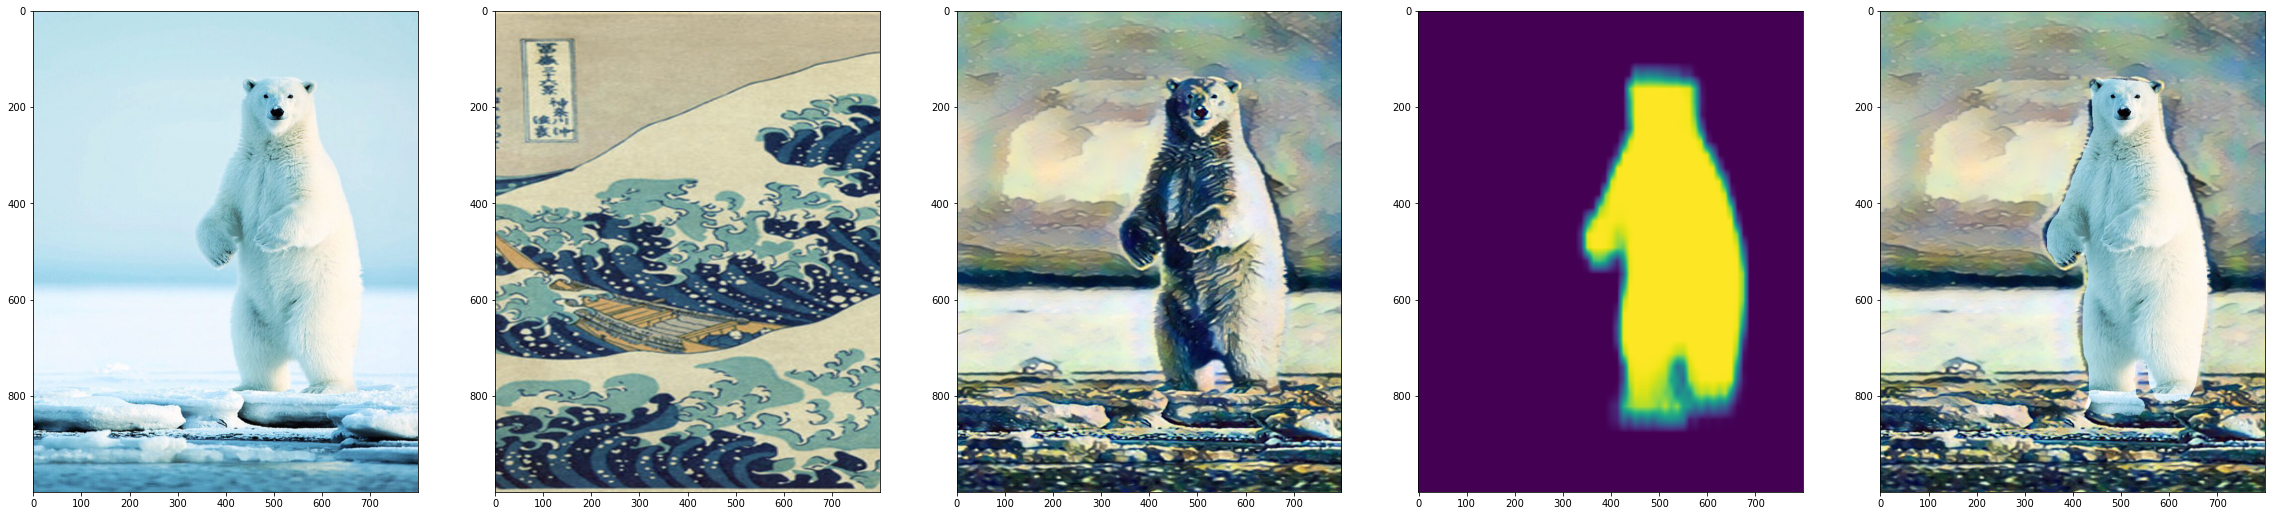

In [85]:
plt.figure(figsize=(5*8, 10))
plt.subplot(1, 5, 1)
imshow(content_image)
plt.subplot(1, 5, 2)
imshow(style_image)
plt.subplot(1, 5, 3)
imshow(transfer_image)
plt.subplot(1, 5, 4)
plt.imshow(seg_numpy)
plt.subplot(1, 5, 5)
imshow(torch.tensor((transfer_image.detach().cpu().numpy())*content_blank_img) + (content_image.cpu().numpy()*(1-content_blank_img)))
plt.show()